In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib import path
from skimage.segmentation import active_contour

**Cargo el canal verde de la imagen, ya que es el que contiene mayor información para nuestro problema.**

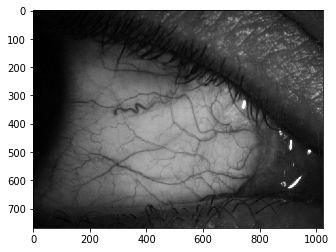

In [567]:
# name = 'BN_024_1.1.jpg'
# name = 'BT_03_1.BMP'
# name = 'BT_04_1.BMP'
# name = 'BN_15_1.BMP'
# name = 'BN_19_1.BMP'
# name = 'BN_058_2.jpg'
# name = 'BT_13_2.BMP'
name = 'BN_12_2.5.BMP'
# name = 'BT_12_2.5.BMP'
# name = 'BN_056_3.jpg'

image_name = 'dataset/'+name
img = cv2.imread(image_name)
# Calculo el valor medio de verde en la fila a altura media
fifth_hgt = int(img.shape[0]/5)
mean_green = np.mean(img[2*fifth_hgt:3*fifth_hgt, :, 1])
green_im = img[:,:,1]
plt.imshow(green_im, cmap='gray')
plt.show()

**Aplico una gaussiana para difuminar.**

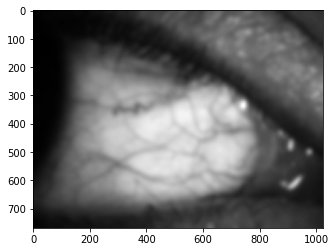

In [568]:
blur = cv2.GaussianBlur(green_im,(51,51),0)
plt.imshow(blur, cmap='gray')
plt.show()

**Umbralizo con el valor medio de verde en la fila a media altura.**

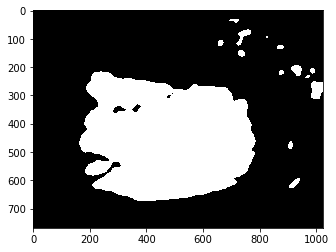

In [569]:
ret,thresh = cv2.threshold(blur,mean_green,255,0)
plt.imshow(thresh, cmap='gray')
plt.show()

**Obtengo la mayor región.**

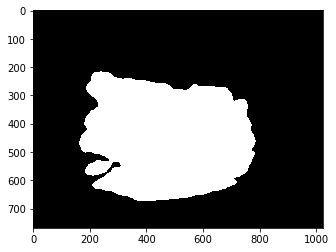

In [570]:
_, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
mask = np.zeros(img.shape[:-1],np.uint8)
best_cnt = contours[0]
max_a = 0
for cnt in contours:
    a = cv2.contourArea(cnt)
    if a > max_a:
        max_a = a
        best_cnt = cnt
cv2.drawContours(mask,[best_cnt],-1,(1,1,1),-1)
plt.imshow(mask, cmap='gray')
plt.show()

**Aplico un filtro de cierre para cerrar huecos.**

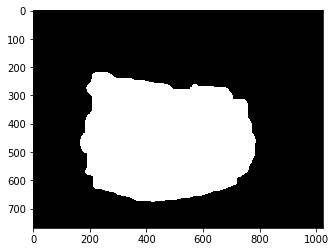

In [571]:
kernel = np.ones((50,50), np.uint8)
closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
# cl *= mask
plt.imshow(closing,cmap='gray')
plt.show()
mask = closing

**Lo uso como máscara para la imagen.**  
En lugar de la imagen original utilizo la inversa del segundo canal del espacio de color Lab,  
ya que es la que más resalta los vasos sobre el fondo.  
Además, le aplico una ecualización de histograma CLAHE.

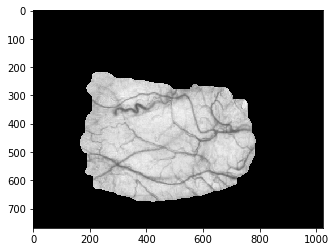

In [572]:
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(255-img_lab[:,:,1])
cl *= mask
plt.imshow(cl, cmap='gray')
plt.show()

**Inicializo un snake elíptico sobre la zona calculada**

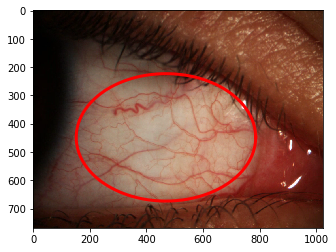

In [573]:
ellipse = cv2.fitEllipse(best_cnt)
center_x, center_y = ellipse[0] 
s = np.linspace(0, 2*np.pi, 200) # 200 angulos equiespaciados entre 0 y 2pi
x = center_x + int(ellipse[1][1]/2)*np.cos(s) # Coordenadas de una elipse con centro  (center_x,center_y) y radios h/2 y w/2
y = center_y + int(ellipse[1][0]/2)*np.sin(s)
init = np.array([x,y]).transpose()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')
plt.plot(init[:,0], init[:,1], '-r', lw=3)
plt.show()

**y lo calculo sobre la imagen previamente mencionada.**

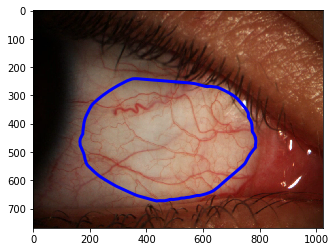

In [574]:
snake = active_contour(cl, init, alpha=0.01, beta=0.01, w_line=0, w_edge=0.5)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')
plt.plot(snake[:,0], snake[:,1], '-b', lw=3)
plt.show()

**El resultado es una región con bordes más suaves y que elimina 'penínsulas'.**

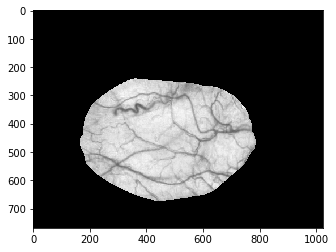

In [575]:
# Convert the contour into a closed path
closed_path = path.Path(snake)
# closed_path = path.Path(init)
# Get the points that lie within the closed path
idx = np.array([[(i,j) for i in range(cl.shape[1])] for j in range(cl.shape[0])]).reshape(np.prod(cl.shape),2)
mask = closed_path.contains_points(idx).reshape(cl.shape)
cl = clahe.apply(255-img_lab[:,:,1])
cl *= mask
plt.imshow(cl, cmap='gray')
plt.show()

**Difumino esta región y aplico una umbralización adaptativa para encontrar bordes, que serán los vasos.**

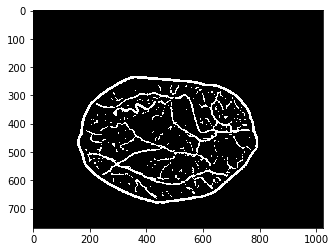

In [576]:
blur = cv2.GaussianBlur(cl,(5,5),0)
adaptThr = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 35, 6)
adaptThr = 255 - adaptThr
plt.imshow(adaptThr, cmap='gray')
plt.show()

**Elimino el borde exterior.**

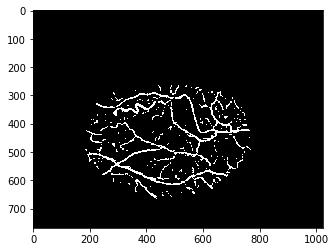

In [577]:
_, contours, hierarchy = cv2.findContours(adaptThr,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
outer_cnt = contours[0]
max_a = 0
for cnt in contours:
    a = cv2.contourArea(cnt)
    if a > max_a:
        max_a = a
        outer_cnt = cnt
copy = adaptThr.copy()
cv2.drawContours(copy,[outer_cnt],-1,(0,255,0),30)
plt.imshow(copy, cmap = 'gray')
plt.show()

**Calculo el porcentaje de vasos detectados con respecto al área total.**

In [578]:
hist_count, _ = np.histogram(copy, 2, [0,256])
mask_count, _ = np.histogram(mask, 2, [0,256])
score = hist_count[1]/mask_count[0]
print('{}: {:.4f}'.format(name,score))

BN_12_2.5.BMP: 0.0361


**Discretizo el score calculado.**

In [579]:
if score < 0.02:
    discrete = 1
elif score < 0.025:
    discrete = 1.5
elif score < 0.03:
    discrete = 2
elif score < 0.05:
    discrete = 2.5
else:
    discrete = 3
print(discrete)

2.5


In [580]:
disc = discrete
if disc < 1.5:
    print('Nivel bajo')
elif disc <= 1.5:
    print('Nivel bajo-medio')
elif disc < 2.5:
    print('Nivel medio')
elif disc <=2.5:
    print('Nivel medio-alto')
else:
    print('Nivel alto')

Nivel medio-alto


----------------------------------------------------------------------

In [527]:
name_list = ['BN_024_1.1.jpg', 'BT_03_1.BMP', 'BT_04_1.BMP', 'BN_15_1.BMP', 'BN_19_1.BMP', 'BN_058_2.jpg', 'BT_13_2.BMP', 'BN_12_2.5.BMP', 'BT_12_2.5.BMP', 'BN_056_3.jpg']
class_list = [1,1,1,1,1,2,2,2.5,2.5,3]
for n, name in enumerate(name_list):
    print(class_list[n],name)

1 BN_024_1.1.jpg
1 BT_03_1.BMP
1 BT_04_1.BMP
1 BN_15_1.BMP
1 BN_19_1.BMP
2 BN_058_2.jpg
2 BT_13_2.BMP
2.5 BN_12_2.5.BMP
2.5 BT_12_2.5.BMP
3 BN_056_3.jpg


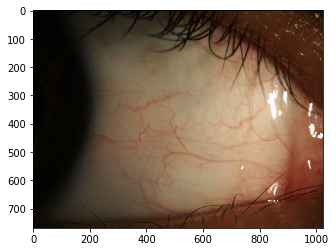

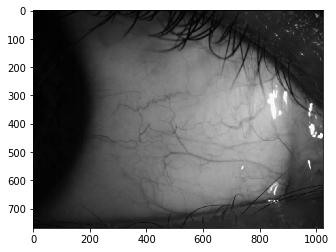

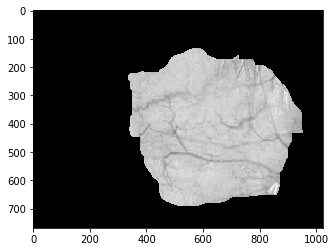

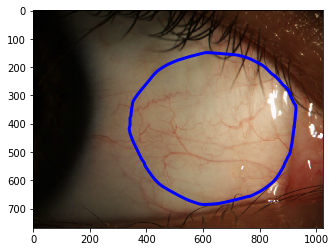

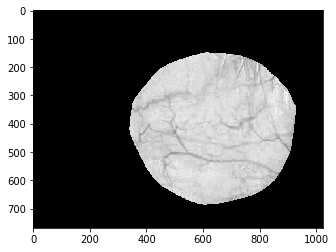

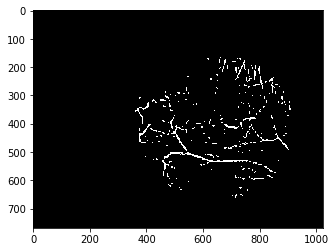

BN_024_1.1.jpg: 0.0178


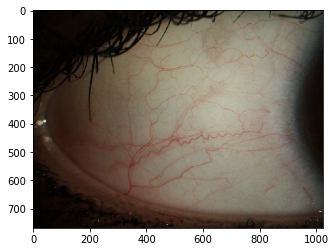

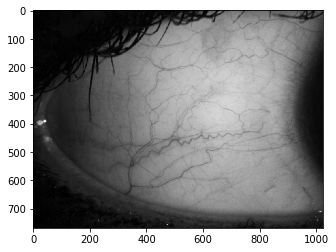

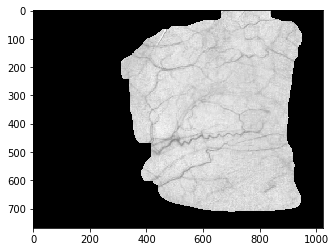

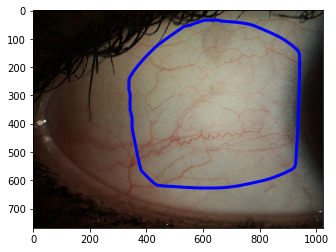

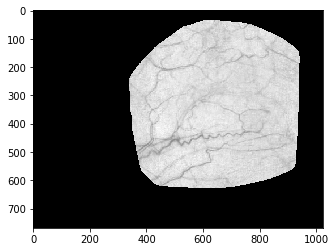

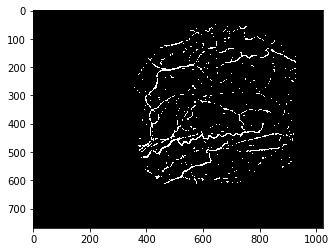

BT_03_1.BMP: 0.0257


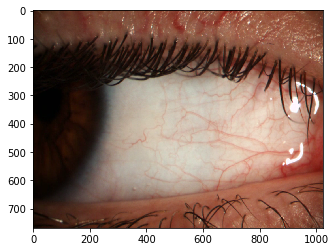

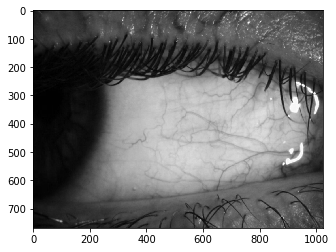

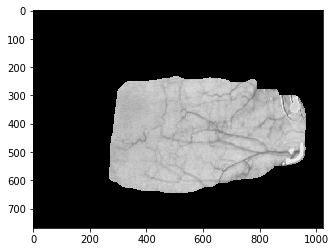

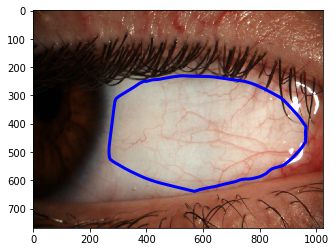

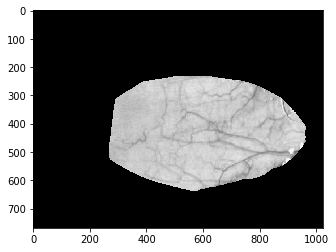

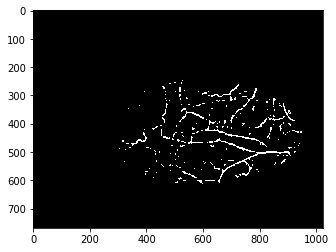

BT_04_1.BMP: 0.0194


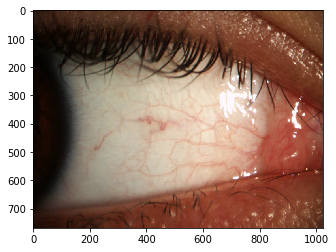

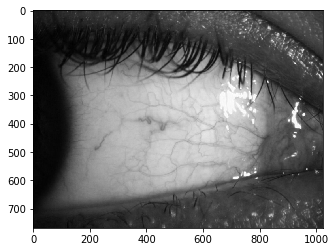

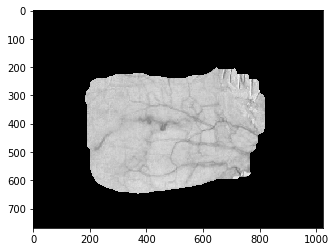

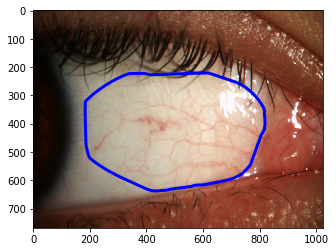

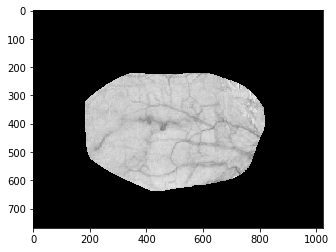

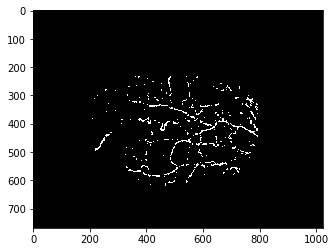

BN_15_1.BMP: 0.0163


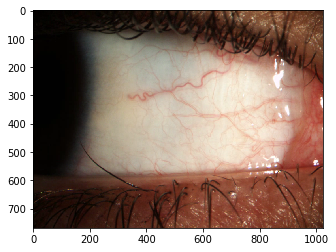

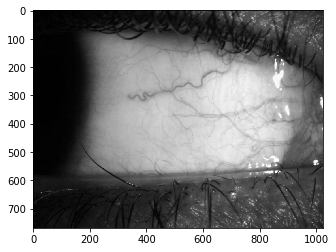

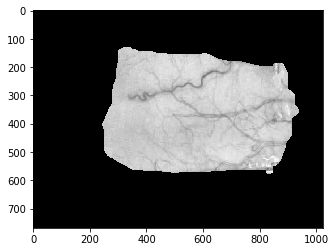

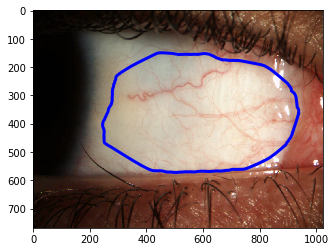

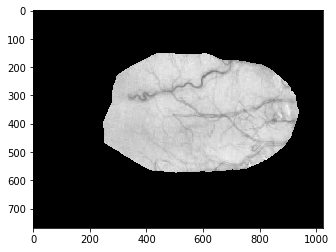

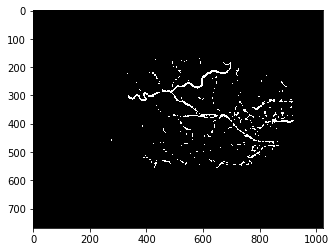

BN_19_1.BMP: 0.0169


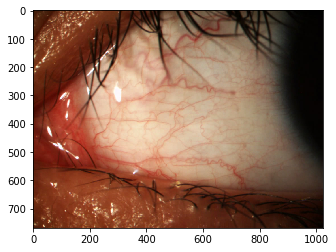

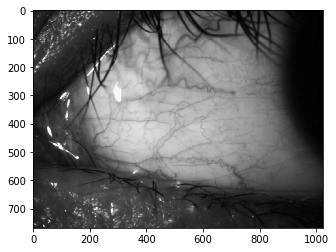

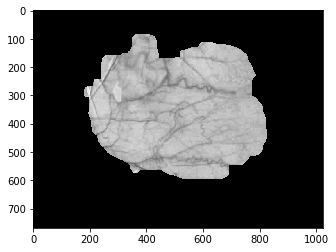

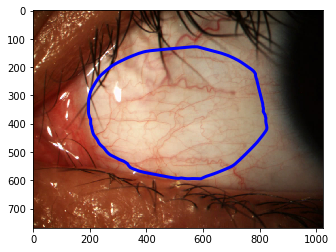

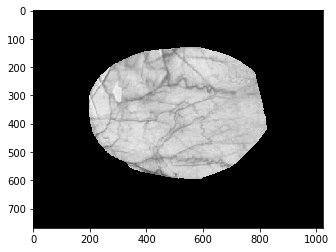

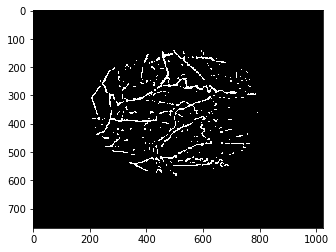

BN_058_2.jpg: 0.0299


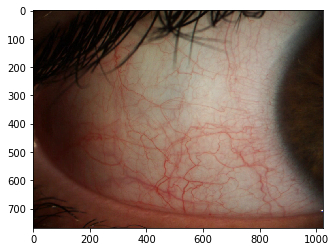

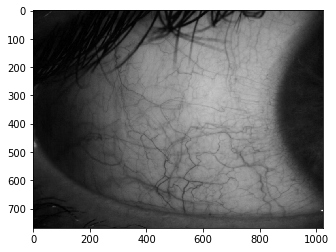

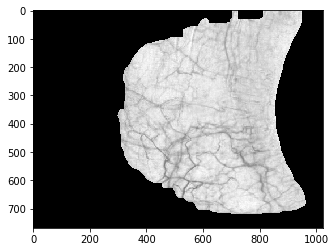

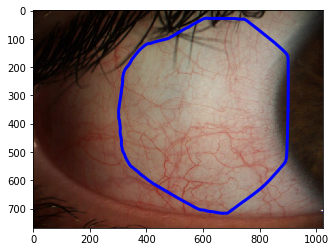

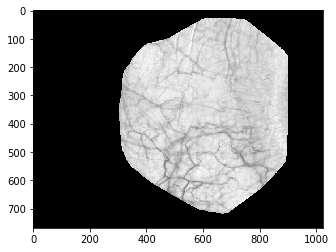

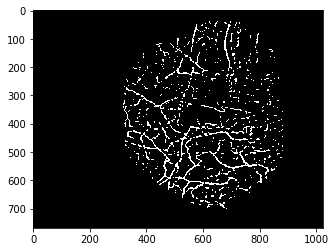

BT_13_2.BMP: 0.0433


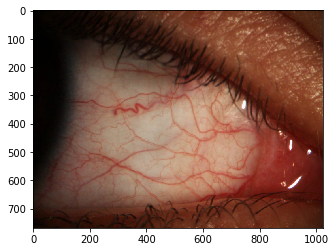

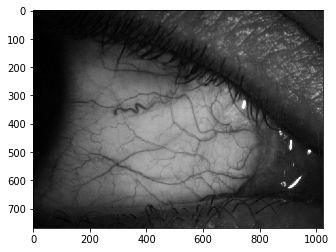

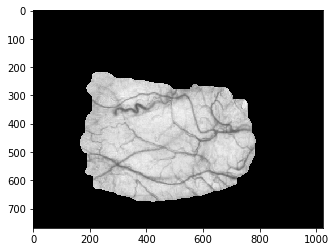

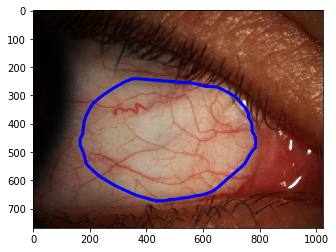

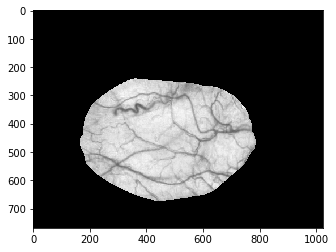

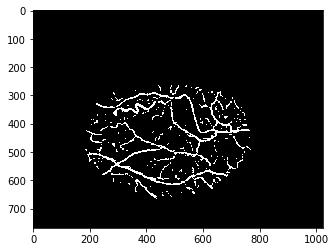

BN_12_2.5.BMP: 0.0361


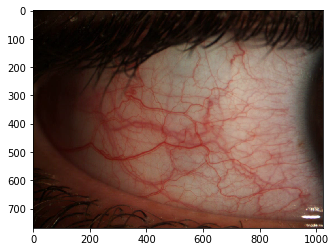

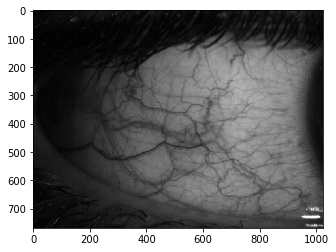

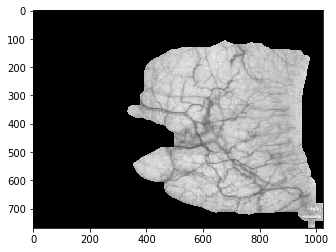

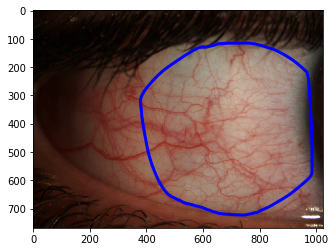

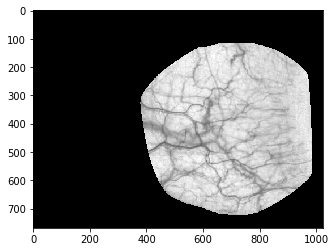

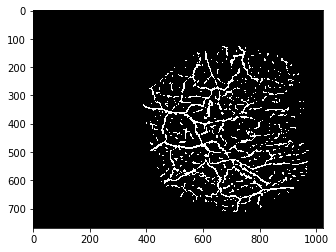

BT_12_2.5.BMP: 0.0534


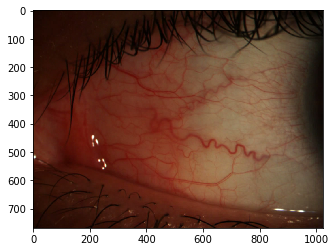

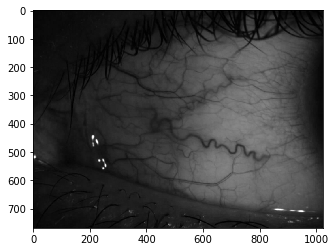

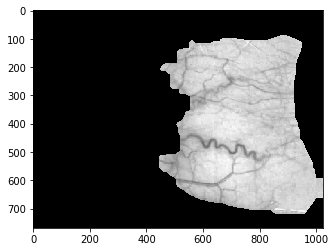

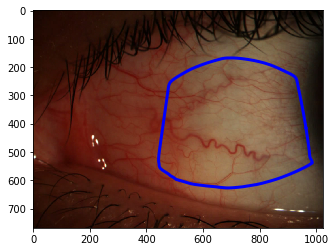

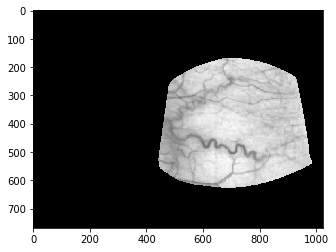

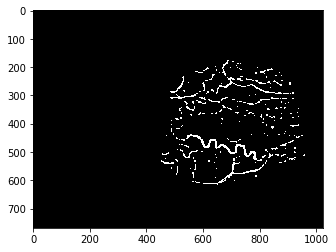

BN_056_3.jpg: 0.0221


In [529]:
name_list = ['BN_024_1.1.jpg', 'BT_03_1.BMP', 'BT_04_1.BMP', 'BN_15_1.BMP', 'BN_19_1.BMP', 'BN_058_2.jpg', 'BT_13_2.BMP', 'BN_12_2.5.BMP', 'BT_12_2.5.BMP', 'BN_056_3.jpg']
class_list = [1,1,1,1,1,2,2,2.5,2.5,3]
scores = []
save_fig = False
for n, name in enumerate(name_list):
    image_name = 'dataset/'+name
    img = cv2.imread(image_name)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if save_fig:
        plt.savefig('{}_{}.png'.format(class_list[n],name))
    plt.show()
    
    fifth_hgt = int(img.shape[0]/5)
    mean_green = np.mean(img[2*fifth_hgt:3*fifth_hgt, :, 1])
    green_im = img[:,:,1]
    plt.imshow(green_im, cmap='gray')
    if save_fig:
        plt.savefig('{}_{}-1_green.png'.format(class_list[n],name))
    plt.show()
    
    blur = cv2.GaussianBlur(green_im,(51,51),0)
#     plt.imshow(blur, cmap='gray')
#     plt.show()
    
    ret,thresh = cv2.threshold(blur,mean_green,255,0)
#     plt.imshow(thresh, cmap='gray')
#     plt.show()
    
    _, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
    mask = np.zeros(img.shape[:-1],np.uint8)
    best_cnt = contours[0]
    max_a = 0
    for cnt in contours:
        a = cv2.contourArea(cnt)
        if a > max_a:
            max_a = a
            best_cnt = cnt
    cv2.drawContours(mask,[best_cnt],-1,(1,1,1),-1)
#     plt.imshow(mask, cmap='gray')
#     plt.show()
    
    kernel = np.ones((50,50), np.uint8)
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # cl *= mask
#     plt.imshow(closing,cmap='gray')
#     plt.show()
    mask = closing
    
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(255-img_lab[:,:,1])
    cl *= mask
    plt.imshow(cl, cmap='gray')
    if save_fig:
        plt.savefig('{}_{}-2_cl_mask.png'.format(class_list[n],name))
    plt.show()
    
    ellipse = cv2.fitEllipse(best_cnt)
    center_x, center_y = ellipse[0] 
    s = np.linspace(0, 2*np.pi, 200) # 200 angulos equiespaciados entre 0 y 2pi
    x = center_x + int(ellipse[1][1]/2)*np.cos(s) # Coordenadas de una elipse con centro  (center_x,center_y) y radios h/2 y w/2
    y = center_y + int(ellipse[1][0]/2)*np.sin(s)
    init = np.array([x,y]).transpose()
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')
#     plt.plot(init[:,0], init[:,1], '-r', lw=3)
#     plt.show()
    
    snake = active_contour(cl, init, alpha=0.01, beta=0.01, w_line=0, w_edge=0.5)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.plot(snake[:,0], snake[:,1], '-b', lw=3)
    if save_fig:
        plt.savefig('{}_{}-3_snake.png'.format(class_list[n],name))
    plt.show()
    
    # Convert the contour into a closed path
    closed_path = path.Path(snake)
    # Get the points that lie within the closed path
    idx = np.array([[(i,j) for i in range(cl.shape[1])] for j in range(cl.shape[0])]).reshape(np.prod(cl.shape),2)
    mask = closed_path.contains_points(idx).reshape(cl.shape)
    cl = clahe.apply(255-img_lab[:,:,1])
    cl *= mask
    plt.imshow(cl, cmap='gray')
    if save_fig:
        plt.savefig('{}_{}-4_snake_mask.png'.format(class_list[n],name))
    plt.show()
    
    blur = cv2.GaussianBlur(cl,(5,5),0)
    adaptThr = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 35, 6)
    adaptThr = 255 - adaptThr
#     plt.imshow(adaptThr, cmap='gray')
#     plt.show()
    
    _, contours, hierarchy = cv2.findContours(adaptThr,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
    outer_cnt = contours[0]
    max_a = 0
    for cnt in contours:
        a = cv2.contourArea(cnt)
        if a > max_a:
            max_a = a
            outer_cnt = cnt
    copy = adaptThr.copy()
    cv2.drawContours(copy,[outer_cnt],-1,(0,255,0),30)
    plt.imshow(copy, cmap = 'gray')
    if save_fig:
        plt.savefig('{}_{}-5_contours.png'.format(class_list[n],name))
    plt.show()
    
    hist_count, _ = np.histogram(copy, 2, [0,256])
    mask_count, _ = np.histogram(mask, 2, [0,256])
    score = hist_count[1]/mask_count[0]
    print('{}: {:.4f}'.format(name,score))
    scores.append(score)

In [538]:
discrete = []
for score in scores:
    if score < 0.02:
        discrete.append(1)
    elif score < 0.025:
        discrete.append(1.5)
    elif score < 0.03:
        discrete.append(2)
    elif score < 0.05:
        discrete.append(2.5)
    else:
        discrete.append(3)
for disc in discrete:
    print(disc)

1
2
1
1
1
2
2.5
2.5
3
1.5


In [548]:
def classify(values):
    for n,disc in enumerate(values):
        if disc < 1.5:
            print('{} - Nivel bajo'.format(n))
        elif disc <= 1.5:
            print('{} - Nivel bajo-medio'.format(n))
        elif disc < 2.5:
            print('{} - Nivel medio'.format(n))
        elif disc <=2.5:
            print('{} - Nivel medio-alto'.format(n))
        else:
            print('{} - Nivel alto'.format(n))

In [552]:
print('Ground truth:')
classify(class_list)
print('--------------------')
print('Results:')
classify(discrete)

Ground truth:
0 - Nivel bajo
1 - Nivel bajo
2 - Nivel bajo
3 - Nivel bajo
4 - Nivel bajo
5 - Nivel medio
6 - Nivel medio
7 - Nivel medio-alto
8 - Nivel medio-alto
9 - Nivel alto
--------------------
Results:
0 - Nivel bajo
1 - Nivel medio
2 - Nivel bajo
3 - Nivel bajo
4 - Nivel bajo
5 - Nivel medio
6 - Nivel medio-alto
7 - Nivel medio-alto
8 - Nivel alto
9 - Nivel bajo-medio
